<a href="https://colab.research.google.com/github/doodger/dataScience/blob/development/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Under construction
This project seeks to compare demographic trends to historical financial returns. The project started out with historical American demographic trends and S&P 500 trends. Later on, Japanese demographic trends and Nikkei 225 trends were added to the project, providing an alternative source of data with vastly different.

As a training exercise, the entire chain of things added and tested was kept in in a linear ordear, to facilitate review by a mentor with experience as Data Scientist.

Wish list and to-do


*   The notebook has grown to an unwieldy size. Eventually separating utility code and functions from the notebook might be a worthwhile endeavor.


In [9]:
#General Imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LassoCV,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
!pip install xgboost
from xgboost import XGBRegressor #creates annoying warnings
from tqdm import tqdm


import warnings  #code to supress warnings; dangerous; useful for xgboost module
warnings.filterwarnings("ignore")


# Building a joint dataset for American data
### Sources of data
To begin with, two sources of data have been collected for the task ahead:


*   American demographic data from 1960 to 2018. This dataset tracks the percentage of the population for each year as divided into 0 to 4 years old male, 0 to 4 years old female, 5 to 9 years old male, 5 to 9 years old female, and so on until the final 80 years and more group of men and of women is reached. In total, this data is made up of 34 age groups over 59 years. The data has been retrieved from the World Bank's open data initiative.
*   S&P 500 data from 1960 to 2018. This dataset tracks a number of variables such as monthly highs, lows, closes and volatility of 500 large American corporations listed on stock exchanges. This monthly data collected during 59 years is averaged into 59 annual means of the highs, lows, closes and volatily. A final variable is also calculated, the annual percentage variation of the close value.

### Use of yearly percentages as variables
Over the 1960 to 2018 period, both the American population and its stock market has seen great increase in population and valuation, respectively. To account for this, percentage values will be used instead of raw values. As such year after year the breakdown of the american population into various age and gender groups will be compared to the percentage of gains or losses of the stock market for that year.

In [10]:
#Data imports USA
populationURL = "https://raw.githubusercontent.com/doodger/dataScience/master/38f6e261-94a4-4bdf-b5db-5d75022e46bb_Data.csv"
SaP500URL = "https://raw.githubusercontent.com/doodger/dataScience/master/%5EGSPC.csv"

pop_df = pd.read_csv(populationURL)
sap_df = pd.read_csv(SaP500URL)

##Data cleaning and sorting for the population

#Demographics data
pop_df.head()
#Rows 35,36 and 37 are rows of Nan
#Rows 38 and 39 only have a value at the head, detailling the database's World bank origin

print("Total missing value for rows 0 to 34:",pop_df.loc[0:34].isnull().sum().sum())
pop_df = pop_df.loc[0:34]

#With the un-needed rows cut off, the dataframe can be reordered so that the rows of population groups
#    are in chronological order
pop_df = pop_df.sort_values("Series Code")
#Row 21 is superfluous (65+ women), and can be deleted. The index are then labeled to a proper order
pop_df = pop_df.drop([21])
pop_df.index= [i for i in range(34)]
#The 17 age groups are now in ascending order for both women and men

Total missing value for rows 0 to 34: 0


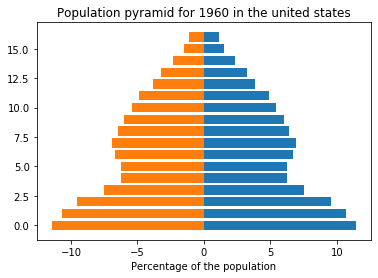

In [11]:
##Visualization

#Sample age pyramid for 1960
yMen = [pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
yWomen = [-pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
#Here the women's number will be in the negative by convention


x = [i for i in range(17)]
ax = plt.subplot(111)
ax.barh(x,yMen)
ax.barh(x,yWomen)
plt.xlabel("Percentage of the population")
ax.set_title("Population pyramid for 1960 in the united states")
plt.show()


Total missing value for S&P data: 0


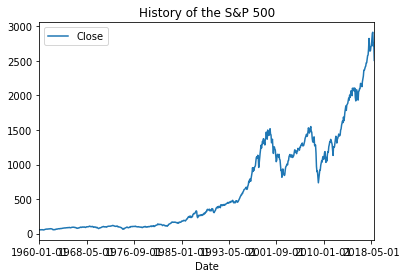

In [12]:
#Financial data

#S&P 500 data
sap_df.head()
print("Total missing value for S&P data:",sap_df.isnull().sum().sum())
#The population data only extends to 2018, and so the 2019 data of the S&P can be cut
#2019 data is from row 708 onward
sap_df = sap_df.loc[0:707]

#History of the S&P500 
sap_df.plot.line(x="Date",y="Close",title = "History of the S&P 500")

## Creating a joint dataset
#Turning the monthly stock market data into annualized data to compare it with the population will be helpful
#To do this a set of yearly statistics for the S&P data will be calculated and afterward both dataframes will be merged into one consolidated dataframe


colAvgClose = [0]*59
colYear = [0]*59
colVolatility = [0]*59
colVolume = [0]*59
colYearlyPercentageVariation = [0]*59
#populating each of the 59 years
for i in range(59):
  colAvgClose[i] = sap_df.loc[i:i+11,"Close"].mean() #yearly mean of closing price
  colVolatility[i] = sap_df.loc[i:i+11,"Close"].std() #experiment to get the volatility in percentage
  colVolume[i] = sap_df.loc[i:i+11,"Close"].mean()

for i in range(1,59):#1960 has no previous year data and thus no percentage variation for now
  colYearlyPercentageVariation[i] = 100*(colAvgClose[i]-colAvgClose[i-1])/colAvgClose[i-1]

#Columns from the S&P set

columns = []
columns.append( ("year", [1960 + i for i in range(59)]) )
columns.append( ("avgClose", colAvgClose) )
columns.append( ("volatility", colVolatility) )
columns.append( ("volume", colVolume) )
columns.append( ("yearPctVar", colYearlyPercentageVariation))
#Columns from the pop set
pop_columns = ["0t4F","0t4M","5t9F","5t9M","10t14F","10t14M","15t19F","15t19M",
               "20t24F","20t24M","25t29F","25t29M","30t34F", "30t34M","35t39F",
                "35t39M","40t44F", "40t44M","45t49F","45t49M",
           "50t54F","50t54M","55t59F","55t59M","60t64F", "60t64M","65t69F","65t69M",
           "70t74F","70t74M",
           "75t79F","75t79M","80pF","80pM"]
for i in range(34):
  columns.append( (pop_columns[i], pd.to_numeric(pop_df.loc[i,"1960 [YR1960]":"2018 [YR2018]"]) ) ) #columns were being copied as object instead of numeric

#creating the joint dataframe
merged_df = pd.DataFrame(dict(columns))
merged_df.index = [i for i in range(59)] #To get rid of inherited index names from pop_df


# Exploratory data analysis
### Linear plots
To begin with, we investigate if there is linear correlation between financial growth and any of the American population groups. Below, the evolution of the S&P 500 is plotted against four groups: men and women aged between 20 and 24, as well as men aged 40 to 44 and men aged 70 to 74.

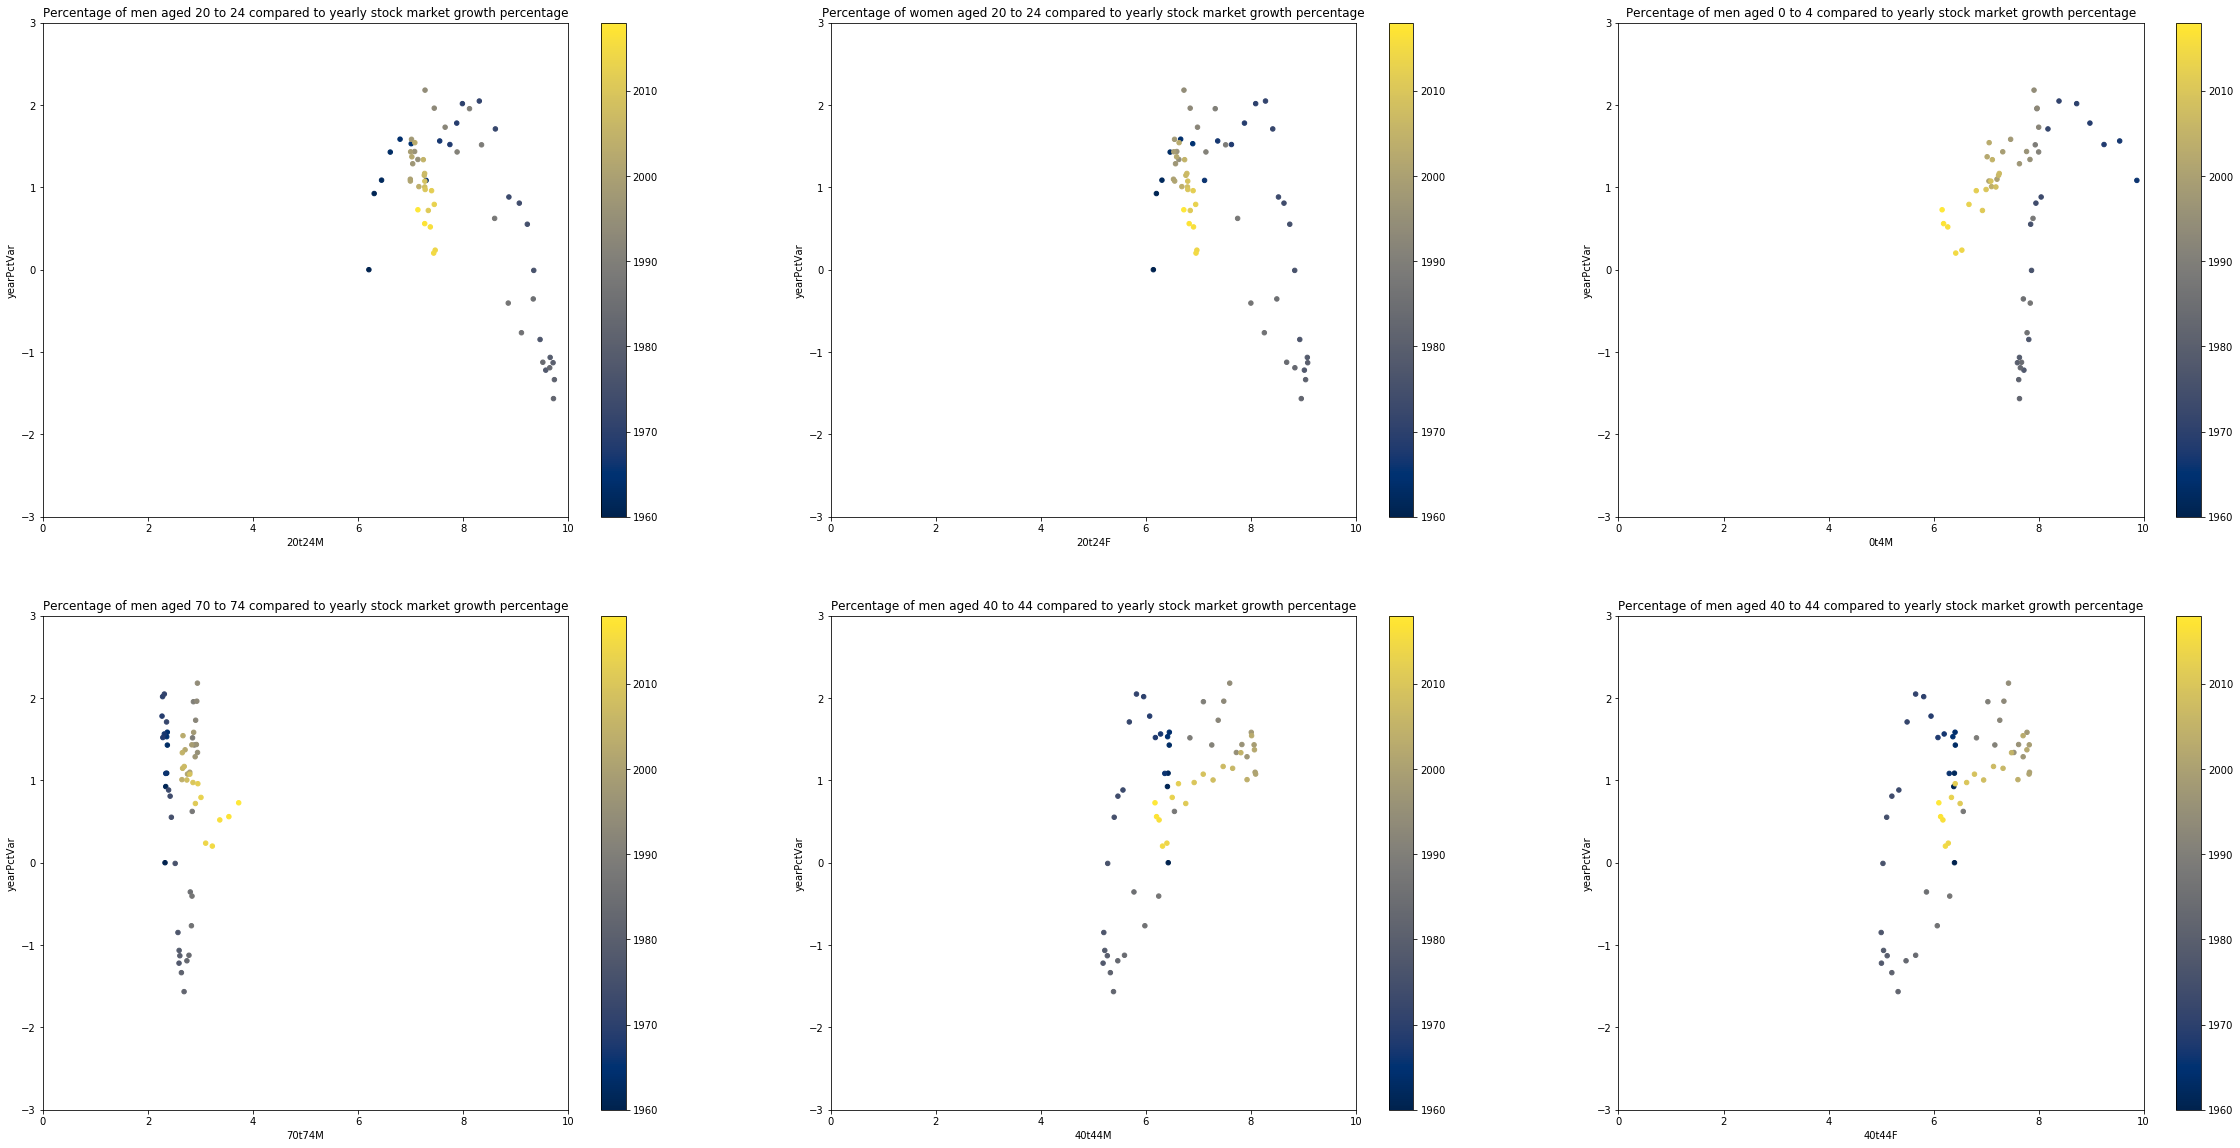

In [13]:
#A few scatter plots of demographic group versus the yearly growth
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(40,20))
plt.setp(axes, xlim=(0,10),ylim=(-3,3))
merged_df.plot.scatter(ax=axes[0,0],x="20t24M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 20 to 24 compared to yearly stock market growth percentage")#young men vs %-variation
merged_df.plot.scatter(ax=axes[0,1],x="20t24F", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of women aged 20 to 24 compared to yearly stock market growth percentage")#young women vs %-variation
merged_df.plot.scatter(ax=axes[0,2],x="0t4M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 0 to 4 compared to yearly stock market growth percentage")#male babies vs %-variation
merged_df.plot.scatter(ax=axes[1,0],x="70t74M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 70 to 74 compared to yearly stock market growth percentage")#male retirees vs %-variation
merged_df.plot.scatter(ax=axes[1,1],x="40t44M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 40 to 44 compared to yearly stock market growth percentage")#male midlife vs %-variation
merged_df.plot.scatter(ax=axes[1,2],x="40t44F", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 40 to 44 compared to yearly stock market growth percentage")#male retirees vs %-variation  

Of the four subgroups, men aged 40 to 44 (the bottom right graph) seem to exhibit the most positively correlated link with the stock market. As the proportion of men in this age bracket increase, so does the average yearly stock market growth.

Men and women in their early twenties (the top two graphs), on the other hand, seem to exhibit negative correlation with stock market growth.

The clustering of yellow and blue points points to a weakness of analysing financial information linearly over this period of time. The high growth of the 1960s in America was mostly gone by the 2000s and 2010s, as the American economy matured and the post war boom became distant history. This points to the danger of a model trained on one era underperforming in another as economic realities have changed.

### Correlation heatmap
More generally, correlation is calculated for every pair of variable. Of greatest interest is the correlation of annual percentage growth to the various population groups.

In [14]:
corrMatrix = merged_df.corr() #correlation matrix of the merged df
corrMatrix.style.background_gradient(cmap='PiYG', axis=None)



Observations and curious things:

*   Correlation is strongest between men and women in their 40s and the percentage variation of the stock market. Perhaps 
*   Nevative correlation is at its strongest for people in their 20s with stock market. Perhaps young adults are least likely to invest in the stock market as they are finishing university and starting out their career. 
*   There is a smaller correlation between kids/pre-teens and stock market growth... Perhaps this reflects indirectly that increasing kid population drive the economy. It is also possible that more kids mean that there are more parents in their 30s and 40s, spending more in the middle of their career and preparing to invest.
*   Financial data is not adjusted to population growth, so it's not surprising that as time goes on and more and more people are alive in the US the volume of trading goes up.
*   A standardized variable for volatility behaved exactly as its non-standardized version, and so it was not kept for further study.

### PCA analysis
Next, a primary component analysis of the demographic variable is performed, to see if the collection of demographic group can be brought down to only two or three dimension.


Explained % of variance for 2 component PCA: 0.7500213974671512
Explained % of variance for 3 component PCA: 0.9376381886183611


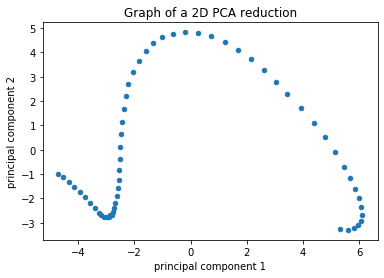

In [15]:
X = merged_df.loc[:,"0t4F":"80pM"] #Don't scale it since the data might not be Gaussian and already same scale?
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalX_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalX_df.plot.scatter('principal component 1', 'principal component 2',title="Graph of a 2D PCA reduction")
print("Explained % of variance for 2 component PCA:",sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalX_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalX_df
print("Explained % of variance for 3 component PCA:",sum(pca.explained_variance_ratio_))


A dimension 3 PCA reduction of the demographic variables explains 93% of the variance within them. At time of writing, a principal component regression has not been attempted yet to predict the stock market variations.

# Model testing
To begin with a few simple linear models are built, using first a 60-40 split of training data and validation data, then a 80-20 split. 

Text(1, 2.7, 'MSE:0.36821032480305954')

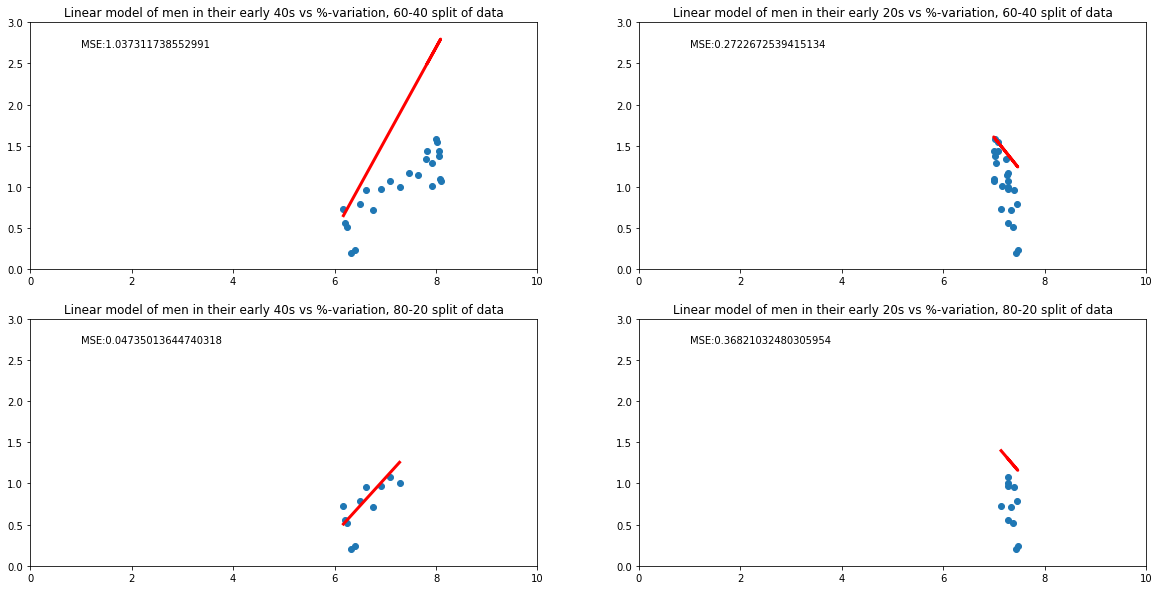

In [16]:
## Model testing


#Just a few linear regressions to begin with?
#A roughly 60-40 split in training and validation is taken
X_train = merged_df.loc[0:35,"0t4F":"80pM"] 
X_test = merged_df.loc[36:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = merged_df.loc[0:35,"yearPctVar"]
y_test = merged_df.loc[36:,"yearPctVar"]

#Simple model where only men of 40 to 44 is used
mod1 = LinearRegression()
mod1.fit(X_train[["40t44M"]],y_train)
result1 = mod1.predict(X_test[["40t44M"]])

#Simple model where men of 20 to 24 is used to predict prices
mod2 = LinearRegression()
mod2.fit(X_train[["20t24M"]],y_train)
result2 = mod2.predict(X_test[["20t24M"]])




#A roughly 80-20 split in training and validation is taken
X_train2 = merged_df.loc[0:47,"0t4F":"80pM"] 
X_test2 = merged_df.loc[48:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train2 = merged_df.loc[0:47,"yearPctVar"]
y_test2 = merged_df.loc[48:,"yearPctVar"]

#Simple model where only men of 40 to 44 is used
mod3 = LinearRegression()
mod3.fit(X_train2[["40t44M"]],y_train2)
result3 = mod3.predict(X_test2[["40t44M"]])

#Simple model where men of 20 to 24 is used to predict prices
mod4 = LinearRegression()
mod4.fit(X_train2[["20t24M"]],y_train2)
result4 = mod4.predict(X_test2[["20t24M"]])

#plots
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(20,10))
plt.setp(axes, xlim=(0,10),ylim=(0,3))

axes[0,0].title.set_text("Linear model of men in their early 40s vs %-variation, 60-40 split of data")
axes[0,0].scatter(x=X_test[["40t44M"]], y=y_test)#old men vs %-variation
axes[0,0].plot(X_test[["40t44M"]],result1, color='red', linewidth=3)
axes[0,0].text(1,2.7,"MSE:"+str(mean_squared_error(y_test,result1)))

axes[0,1].title.set_text("Linear model of men in their early 20s vs %-variation, 60-40 split of data")
axes[0,1].scatter(x=X_test[["20t24M"]], y=y_test)#young men vs %-variation
axes[0,1].plot(X_test[["20t24M"]],result2, color='red', linewidth=3)
axes[0,1].text(1,2.7,"MSE:"+str(mean_squared_error(y_test,result2)))

axes[1,0].title.set_text("Linear model of men in their early 40s vs %-variation, 80-20 split of data")
axes[1,0].scatter(x=X_test2[["40t44M"]], y=y_test2)#old men vs %-variation
axes[1,0].plot(X_test2[["40t44M"]],result3, color='red', linewidth=3)
axes[1,0].text(1,2.7,"MSE:"+str(mean_squared_error(y_test2,result3)))

axes[1,1].title.set_text("Linear model of men in their early 20s vs %-variation, 80-20 split of data")
axes[1,1].scatter(x=X_test2[["20t24M"]], y=y_test2)#old men vs %-variation
axes[1,1].plot(X_test2[["20t24M"]],result4, color='red', linewidth=3)
axes[1,1].text(1,2.7,"MSE:"+str(mean_squared_error(y_test2,result4)))


It is interesting to see the best and worst performances are both for the models based solely on the men in their early 40s. The top left 60-40 model has an MSE of around 1 (certainly not great compared to other benchmarks seen for more complex) models, while the bottom right 80-20 model achieves a MSE of about 0.05, which is in the upper reaches of performance for the various complex models tested later on. The question remains as to the bottom left model is simply "lucky", or the fact that it is exposed to more data increases its performances.

On the right, the two models for men in their 20s sees degraded performance as more data is added. The order of magnitude of performance remains about the same, and presents an acceptable degree of performance when compared to more complex models later on.

### Grab bag of models
From this point on, a range of models are tested for performance. These are:



1.   A linear regression with no regularization.
2.   A linear regression using elastic-net regularization.
3.   A linear regression using lasso regularization.
4.   A 2 depth decision tree
5.   A 5 depth decision tree
6.   A multilayer perceptron regressor
7.   A random forest regressor
8.   A gradient boosted regressor
9.   An XGBregressor.

Uniquely among the collection of models, the 9th model uses exposition to the validation data for early stopping to prevent overfitting. This is detailed in a later section of this notebook. 

### Testing out the models on an 80-20 data split
From there, the performance over 20 trials of the various models trained on the first 80% of data has been calculated over the final 20%. Four models are presented below, each of them judged the most interesting representative of their class: the lasso regularized linear regressor; the five depth decision tree; the multilayer perceptron regressor; and finally, the XGBregressor.

In [0]:
#More model testing, this time a set of models

#Full data, useful for CV methods
X = merged_df.loc[:,"0t4F":"80pM"] 
y = merged_df.loc[:,"yearPctVar"]


#the 80-20 split is retained for the first round of testing
EightyTwenty_X_train = X_train2
EightyTwenty_X_test = X_test2
EightyTwenty_y_train = y_train2
EightyTwenty_y_test = y_test2

def testSetOfModels(X_train = EightyTwenty_X_train, y_train = EightyTwenty_y_train, X_test = EightyTwenty_X_test, y_test = EightyTwenty_y_test, performanceMetric = mean_squared_error, verbose = True):
  #This function aims to test a range of models on various sets of training/test data
  # as well as on many different metrics

  #The verbose parameter outputs the performance of every model as a print

  #By default it uses the 80-20 split data and MSE as a performance metric, and is verbose
  #The verbose

  
  outputPerformance = []

  model1 = LinearRegression()
  model1.fit(X_train,y_train)
  y_pred1 = model1.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred1))
  if verbose == True : print("Linear regression performance using ", str(performanceMetric), ":", performanceMetric(y_test,y_pred1))
  #print("Coefficients for Linear Regression:",model1.coef_)

  model2 = ElasticNet() #Using the ElasticNet regularization method
  model2.fit(X_train,y_train)
  y_pred2 = model2.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred2))
  if verbose == True : print("Elastic net performance using ", str(performanceMetric), ":",outputPerformance[-1])
  #print("Coefficients for Elastic Net:",model2.coef_)


  model3 = Lasso() #Using the Lasso (Or L1 norm)
  model3.fit(X_train,y_train)
  y_pred3 = model3.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred3))
  if verbose == True : print("Lasso performance using ", str(performanceMetric), ":",outputPerformance[-1])
  #print("Coefficients for Lasso:",model3.coef_)


  model4 = DecisionTreeRegressor(max_depth = 2) #2 depth decision tree
  model4.fit(X_train,y_train)
  y_pred4 = model4.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred4))
  if verbose == True : print("2 Depth Decision tree performance using ", str(performanceMetric), ":",outputPerformance[-1])

  model5 = DecisionTreeRegressor(max_depth = 5) #5 depth decision tree
  #MSE varies between being better and worse than 2 depth, this deserves a crossvalidation grid search probably TODO
  model5.fit(X_train,y_train)
  y_pred5 = model5.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred5))
  if verbose == True : print("5 Depth Decision tree performance using ", str(performanceMetric), ":",outputPerformance[-1]) #MSE varies between being better and worse than 2 depth, this deserves a crossvalidation grid search probably TODO

  model6 = MLPRegressor(hidden_layer_sizes = 50, max_iter = 1000) #Standard multilayer perceptron, with 30x1 Layers x depth
  #Very irregular performance; can be good or awful compared to lasso benchmark
  model6.fit(X_train,y_train)
  y_pred6 = model6.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred6))
  if verbose == True : print("50 layers Perceptron Regressor performance using ", str(performanceMetric), ":",outputPerformance[-1]) #MSE varies between being better and worse than 2 depth, this deserves a crossvalidation grid search probably TODO

  model7 = RandomForestRegressor(n_estimators=12) #After testing, a number of 12 trees was decided (p/3)
  model7.fit(X_train,y_train)
  y_pred7 = model7.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred7))
  if verbose == True : print("Default Random Forest performance using ", str(performanceMetric), ":", outputPerformance[-1])

  model8 = GradientBoostingRegressor() #Standard gradient boosting
  model8.fit(X_train,y_train)
  y_pred8 = model8.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred8))
  if verbose == True : print("Default Gradient Boosting performance using ", str(performanceMetric), ":", outputPerformance[-1])

  model9 = XGBRegressor()
  #After investigation, earlier underperformance was caused by massive overfitting. A stopping parameter has thus been added.
  model9.fit(X_train,y_train, early_stopping_rounds = 10, eval_set = [(X_test,y_test)], eval_metric = "rmse", verbose = False)
  y_pred9 = model9.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred9))
  if verbose == True : print("Default XGBoost performance using ", str(performanceMetric), ":", outputPerformance[-1])
  
  return(outputPerformance)



[16:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Text(0, 0.5, 'Log 10-MSE')

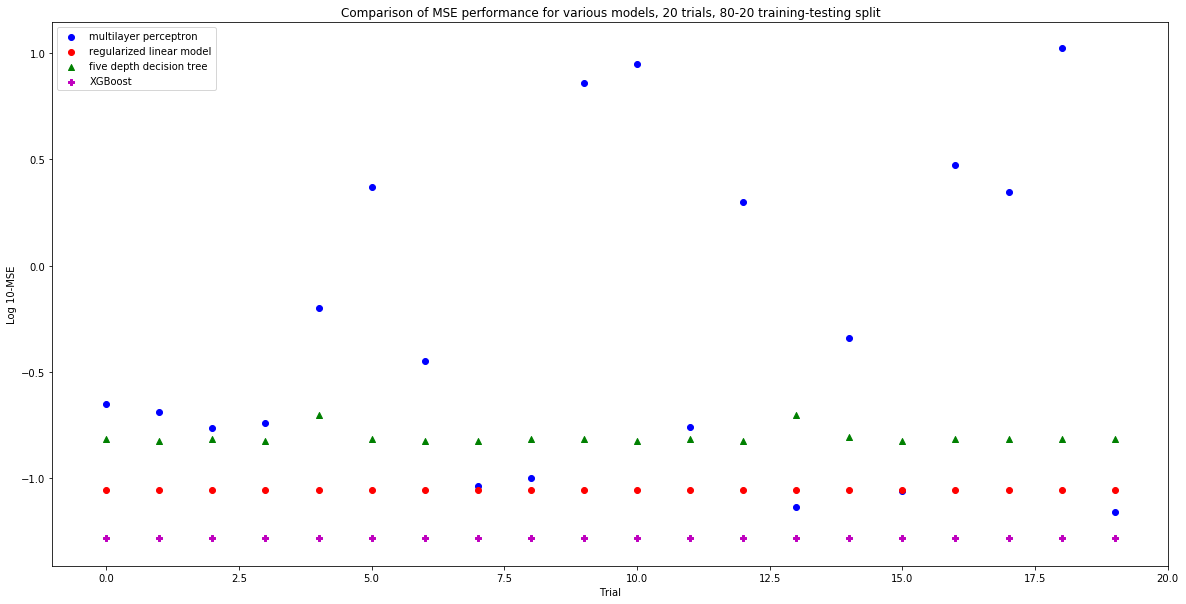

In [18]:
testPoints = []
for i in range (20):
  testPoints.append(testSetOfModels(verbose = False))
fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))

axes.title.set_text("Comparison of MSE performance for various models, 20 trials, 80-20 training-testing split")
plt.scatter([i for i in range(20)], [np.log10(j[5]) for j in testPoints], c='b', label="multilayer perceptron")
plt.scatter([i for i in range(20)], [np.log10(j[2]) for j in testPoints], c='r', label="regularized linear model")
plt.scatter([i for i in range(20)], [np.log10(j[4]) for j in testPoints], c='g', marker = "^", label="five depth decision tree")
plt.scatter([i for i in range(20)], [np.log10(j[8]) for j in testPoints], c='m', marker = "P", label="XGBoost")
axes.legend()
plt.xlabel("Trial")
plt.ylabel("Log 10-MSE")


This first run of performance tests on a 80-20 data splits shows a few interesting topics.

*   A regularized linear regressions offer a good benchmark for model comparison, with its MSE of 0.08 using lasso regularization, and 0.12 using ridge regularization. 
*   The second best method in term of performance tends to be the 50 layer perceptron. However its performance on the 80-20 training-test set is unreliable; at times the perceptron has a MSE on the same order as the regularized linear regression. Other times it performs on the order of 100 times worse.
* Decision trees of various depth as well as random forest and xgboost perform worse than regularized linear regression, their MSE varying slightly for each iteration.

It remains to be seen if the performance of each model might improve or decrease on differently arrayed data, or on a bigger dataset. Tuning each model might also increase its individual performance and dethrone regularized linear regression as the most consistently performant model.

***
Further tuning of XGBoost has made it both the most reliable and performant method on the initial set of 80-20 data, beating out a regularized linear model.

### Nested Validation
Nested Validation sees the model trained and then tested on increasingly large periods of time. This method of validation on time series gives several different test sets, and allows a glimpse of performance across different type of "futures" the model might be called to predict.  A weakness of this approach for this data set is that as there are few data points, the training set of years will always cover a good percentage of the total years. That said, nested validation remains helpful, as various time periods of growth and losses on the markets are tested.



In [0]:
def nestedValidation(mergedDataframe):
  #This function will train a set of model through several periods and judge their performance
  #It takes as input a merged dataframe such as the American or Japanese one
  
  #First, the first 25 year will serve as training data and the next 10 year will serve as validation.
  #From there in 10 year increments the model will explore data up to 2019

  #Each period is tested 20 times

  results1 = []
  results2 = []
  results3 = []
  for i in tqdm(range (20)):
    results1.append(testSetOfModels(X_train = mergedDataframe.loc[0:25,"0t4F":"80pM"],
                  X_test = mergedDataframe.loc[26:35,"0t4F":"80pM"],
                  y_train = mergedDataframe.loc[0:25,"yearPctVar"],
                  y_test = mergedDataframe.loc[26:35,"yearPctVar"], verbose=False))
    results2.append(testSetOfModels(X_train = mergedDataframe.loc[0:35,"0t4F":"80pM"],
                  X_test = mergedDataframe.loc[36:45,"0t4F":"80pM"],
                  y_train = mergedDataframe.loc[0:35,"yearPctVar"],
                  y_test = mergedDataframe.loc[36:45,"yearPctVar"], verbose=False))
    results3.append(testSetOfModels(X_train = mergedDataframe.loc[0:45,"0t4F":"80pM"],
                  X_test = mergedDataframe.loc[46:,"0t4F":"80pM"],
                  y_train = mergedDataframe.loc[0:45,"yearPctVar"],
                  y_test = mergedDataframe.loc[46:,"yearPctVar"], verbose=False))
  return([results1,results2,results3])
  


In [20]:
nestedTesting = nestedValidation(merged_df)

  0%|          | 0/20 [00:00<?, ?it/s]

[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  5%|▌         | 1/20 [00:00<00:18,  1.05it/s]

[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 10%|█         | 2/20 [00:01<00:17,  1.05it/s]

[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 15%|█▌        | 3/20 [00:02<00:13,  1.28it/s]

[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 20%|██        | 4/20 [00:03<00:13,  1.21it/s]

[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 25%|██▌       | 5/20 [00:03<00:11,  1.35it/s]

[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 30%|███       | 6/20 [00:04<00:10,  1.34it/s]

[16:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 35%|███▌      | 7/20 [00:05<00:10,  1.24it/s]

[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 8/20 [00:06<00:09,  1.22it/s]

[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 45%|████▌     | 9/20 [00:07<00:09,  1.19it/s]

[16:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 10/20 [00:08<00:09,  1.06it/s]

[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|██████    | 12/20 [00:09<00:05,  1.39it/s]

[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 65%|██████▌   | 13/20 [00:10<00:04,  1.42it/s]

[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 70%|███████   | 14/20 [00:10<00:04,  1.45it/s]

[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 75%|███████▌  | 15/20 [00:11<00:04,  1.23it/s]

[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 80%|████████  | 16/20 [00:12<00:03,  1.21it/s]

[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 85%|████████▌ | 17/20 [00:13<00:02,  1.21it/s]

[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 90%|█████████ | 18/20 [00:13<00:01,  1.38it/s]

[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 95%|█████████▌| 19/20 [00:14<00:00,  1.47it/s]

[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Log-MSE')

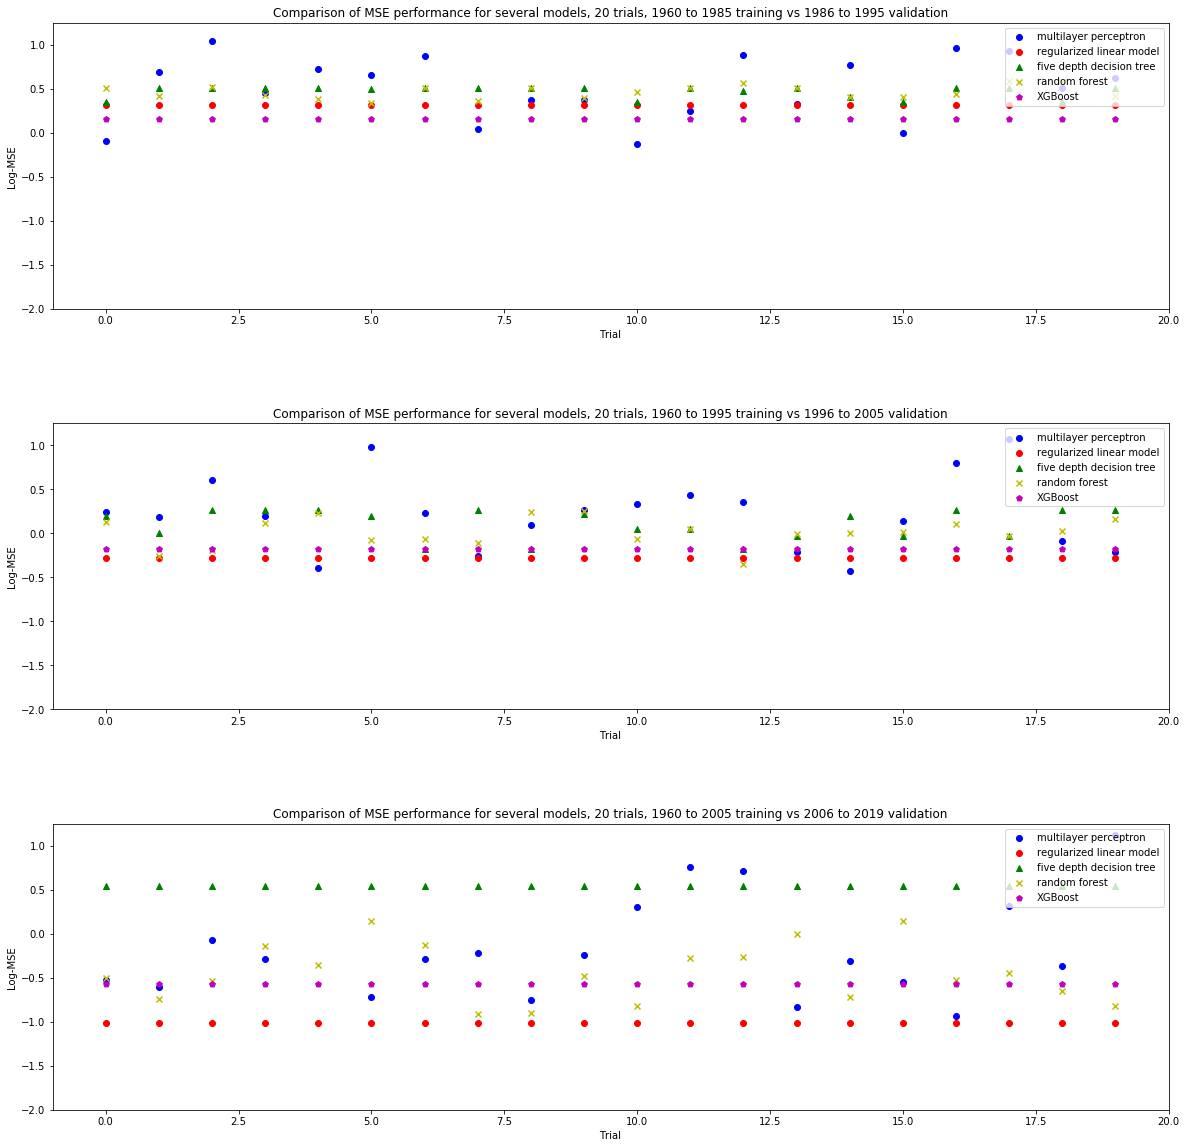

In [21]:
fig, axes = plt.subplots(ncols=1, nrows=3,figsize=(20,20))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes, xlim=(-1,20),ylim=(-2,1.25))


#First time period
axes[0].title.set_text("Comparison of MSE performance for several models, 20 trials, 1960 to 1985 training vs 1986 to 1995 validation")
axes[0].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[0]], c='b', label="multilayer perceptron")
axes[0].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[0]], c='r', label="regularized linear model")
axes[0].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[0]], c='g', marker = "^", label="five depth decision tree")
axes[0].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[0]], c='y', marker = "x", label="random forest")
axes[0].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[0]], c='m', marker = "p", label="XGBoost")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Log-MSE")

#Second time period
axes[1].title.set_text("Comparison of MSE performance for several models, 20 trials, 1960 to 1995 training vs 1996 to 2005 validation")
axes[1].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[1]], c='b', label="multilayer perceptron")
axes[1].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[1]], c='r', label="regularized linear model")
axes[1].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[1]], c='g', marker = "^", label="five depth decision tree")
axes[1].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[1]], c='y', marker = "x", label="random forest")
axes[1].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[1]], c='m', marker = "p", label="XGBoost")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Log-MSE")

#Third time period
axes[2].title.set_text("Comparison of MSE performance for several models, 20 trials, 1960 to 2005 training vs 2006 to 2019 validation")
axes[2].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[2]], c='b', label="multilayer perceptron")
axes[2].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[2]], c='r', label="regularized linear model")
axes[2].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[2]], c='g', marker = "^", label="five depth decision tree")
axes[2].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[2]], c='y', marker = "x", label="random forest")
axes[2].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[2]], c='m', marker = "p", label="XGBoost")
axes[2].legend(loc = "upper right")
axes[2].set_xlabel("Trial")
axes[2].set_ylabel("Log-MSE")

The regularized linear model beats out XGBoost over the second and third tests. XGBoost remains reliably performant, being beaten only ocassionaly by both random forest and the perceptron.

The perceptron's performance varies widly between great (better than linear or XGBoost) and awful (orders of magnitude worse than everything else). Investigation into stabilizing its performance might be worthwhile.

The first time nest sees much degraded performance. It would be interesting to analyse if this is the result of a much smaller pool of training data.

###Dislocated tests
It might also be useful to test the model on periods of time that are separated, to look for more general trends, unconnected to movements of the market in chronological order.

In [0]:
def disjointedValidation():
  #This function will train a set of model on the beginning and ends of the time period,
  # using respectively the end and beginning of the period as validation data.
  #TODO make this dataset neutral
  #Each period is tested 20 times
  results1 = []
  results2 = []
  for i in tqdm(range (20)):
    results1.append(testSetOfModels(X_train = merged_df.loc[0:35,"0t4F":"80pM"],
                  X_test = merged_df.loc[49:59,"0t4F":"80pM"],
                  y_train = merged_df.loc[0:35,"yearPctVar"],
                  y_test = merged_df.loc[49:59,"yearPctVar"], verbose=False))
    results2.append(testSetOfModels(X_train = merged_df.loc[25:59,"0t4F":"80pM"],
                  X_test = merged_df.loc[0:10,"0t4F":"80pM"],
                  y_train = merged_df.loc[25:59,"yearPctVar"],
                  y_test = merged_df.loc[0:10,"yearPctVar"], verbose=False))

  return([results1,results2])
  

In [23]:
disjointedTesting = disjointedValidation()

  5%|▌         | 1/20 [00:00<00:05,  3.54it/s]

[16:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 10%|█         | 2/20 [00:01<00:07,  2.37it/s]

[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 15%|█▌        | 3/20 [00:01<00:07,  2.23it/s]

[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 20%|██        | 4/20 [00:02<00:08,  1.82it/s]

[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 25%|██▌       | 5/20 [00:02<00:07,  2.01it/s]

[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 30%|███       | 6/20 [00:03<00:07,  1.98it/s]

[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 35%|███▌      | 7/20 [00:03<00:05,  2.33it/s]

[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 8/20 [00:04<00:05,  2.00it/s]

[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 45%|████▌     | 9/20 [00:04<00:04,  2.34it/s]

[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 10/20 [00:04<00:04,  2.12it/s]

[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 55%|█████▌    | 11/20 [00:05<00:04,  1.97it/s]

[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|██████    | 12/20 [00:05<00:03,  2.30it/s]

[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 65%|██████▌   | 13/20 [00:06<00:03,  2.26it/s]

[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 70%|███████   | 14/20 [00:06<00:02,  2.10it/s]

[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 75%|███████▌  | 15/20 [00:07<00:02,  2.22it/s]

[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 80%|████████  | 16/20 [00:07<00:02,  1.90it/s]

[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 85%|████████▌ | 17/20 [00:08<00:01,  2.25it/s]

[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 90%|█████████ | 18/20 [00:08<00:00,  2.01it/s]

[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 95%|█████████▌| 19/20 [00:09<00:00,  2.03it/s]

[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 20/20 [00:09<00:00,  2.37it/s]

[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Log 10-MSE')

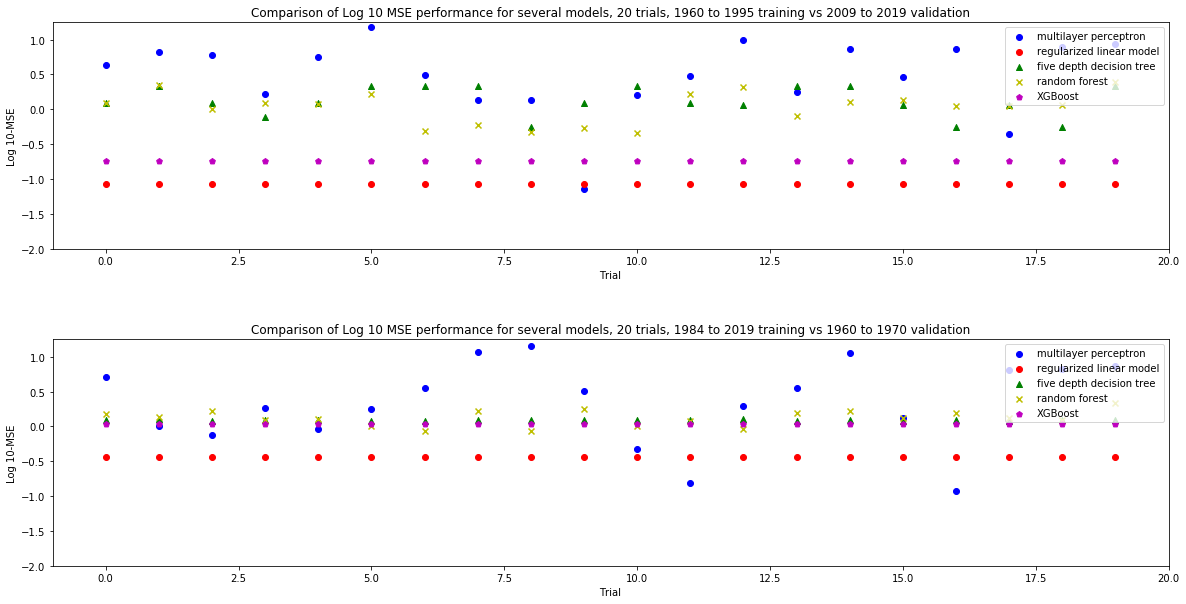

In [24]:
fig, axes = plt.subplots(ncols=1, nrows=2,figsize=(20,10))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes, xlim=(-1,20),ylim=(-2,1.25))


#First time period
axes[0].title.set_text("Comparison of Log 10 MSE performance for several models, 20 trials, 1960 to 1995 training vs 2009 to 2019 validation")
axes[0].scatter([i for i in range(20)], [np.log10(j[5]) for j in disjointedTesting[0]], c='b', label="multilayer perceptron")
axes[0].scatter([i for i in range(20)], [np.log10(j[2]) for j in disjointedTesting[0]], c='r', label="regularized linear model")
axes[0].scatter([i for i in range(20)], [np.log10(j[4]) for j in disjointedTesting[0]], c='g', marker = "^", label="five depth decision tree")
axes[0].scatter([i for i in range(20)], [np.log10(j[6]) for j in disjointedTesting[0]], c='y', marker = "x", label="random forest")
axes[0].scatter([i for i in range(20)], [np.log10(j[8]) for j in disjointedTesting[0]], c='m', marker = "p", label="XGBoost")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Log 10-MSE")

#Second time period
axes[1].title.set_text("Comparison of Log 10 MSE performance for several models, 20 trials, 1984 to 2019 training vs 1960 to 1970 validation")
axes[1].scatter([i for i in range(20)], [np.log10(j[5]) for j in disjointedTesting[1]], c='b', label="multilayer perceptron")
axes[1].scatter([i for i in range(20)], [np.log10(j[2]) for j in disjointedTesting[1]], c='r', label="regularized linear model")
axes[1].scatter([i for i in range(20)], [np.log10(j[4]) for j in disjointedTesting[1]], c='g', marker = "^", label="five depth decision tree")
axes[1].scatter([i for i in range(20)], [np.log10(j[6]) for j in disjointedTesting[1]], c='y', marker = "x", label="random forest")
axes[1].scatter([i for i in range(20)], [np.log10(j[8]) for j in disjointedTesting[1]], c='m', marker = "p", label="XGBoost")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Log 10-MSE")

The first plot sees a model trained in the past try to predict the future. XGBoost performs slightly worse than the regularized linear model.

When trained on data from the end of the dataset, all models take a hit on their accuracy. It is interesting to see the regularized linear models still performing on the order of -0.5 MSE in log 10 base, as this has been the "average" performance across the models. THis suggests that the linear model is not as time dependant as others. 

It is possible that in these tests where the training data is shrunk even further (35 training points compared to 47 for the inital 80-20 test), XGBoost suffers compared to the regularized linear model.


In [25]:
#Mean calculations
#linear model
print("Front to back mean for linear model:", np.mean([(j[2]) for j in disjointedTesting[1]]))
print("Back to front mean for linear model:",np.mean([(j[2]) for j in disjointedTesting[0]]))
print("***")
#multilayer perceptron
print("Front to back mean for perceptron:", np.mean([(j[5]) for j in disjointedTesting[1]]))
print("Back to front mean for perceptron:",np.mean([(j[5]) for j in disjointedTesting[0]]))
print("***")

#decision tree
print("Front to back mean for decision tree:", np.mean([(j[4]) for j in disjointedTesting[1]]))
print("Back to front mean for decision tree:",np.mean([(j[4]) for j in disjointedTesting[0]]))
print("***")

#Random forest
print("Front to back mean for random forest:", np.mean([(j[6]) for j in disjointedTesting[1]]))
print("Back to front mean for random forest:",np.mean([(j[6]) for j in disjointedTesting[0]]))
print("***")

print("Front to back mean for XGBoost:", np.mean([(j[8]) for j in disjointedTesting[1]]))
print("Back to front mean for XGBoost:",np.mean([(j[8]) for j in disjointedTesting[0]]))
print("***")


Front to back mean for linear model: 0.36005964559430576
Back to front mean for linear model: 0.08361563962206736
***
Front to back mean for perceptron: 4.154930006433513
Back to front mean for perceptron: 4.787728462305734
***
Front to back mean for decision tree: 1.23056499324466
Back to front mean for decision tree: 1.4687612482703332
***
Front to back mean for random forest: 1.3624213400395366
Back to front mean for random forest: 1.2067229922317235
***
Front to back mean for XGBoost: 1.0679607192824738
Back to front mean for XGBoost: 0.17876621768282677
***


As can be seen from calculating the means of MSE over the disjointed test, the linear model performs about 4 time worse backward, while the 

[16:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NameError: ignored

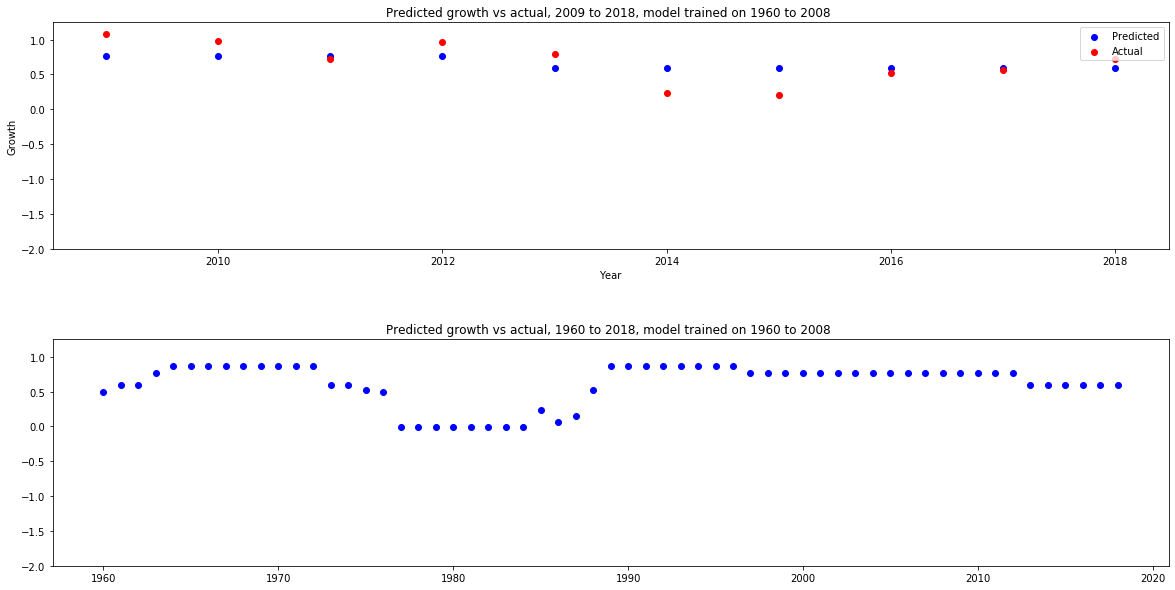

In [26]:
#Forecasting growth of America from 2009 to 2018
X_train = merged_df.loc[0:48,"0t4F":"80pM"]
X_test = merged_df.loc[49:59,"0t4F":"80pM"]
y_train = merged_df.loc[0:48,"yearPctVar"]
y_test = merged_df.loc[49:59,"yearPctVar"]

X_total = merged_df.loc[0:59,"0t4F":"80pM"]

model =XGBRegressor() #Lasso() #The regularized linear model is chosen as the most reliable
model.fit(X_train,y_train, early_stopping_rounds = 10, eval_set = [(X_test,y_test)], eval_metric = "rmse", verbose = False)#X_train,y_train)
y_pred = model.predict(X_test)
y_pred_total = model.predict(X_total)

model2 = DecisionTreeRegressor(max_depth = 2) #2 depth decision tree
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
y_pred2_total = model2.predict(X_total)
fig, axes = plt.subplots(ncols=1, nrows=2,figsize=(20,10))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes,ylim=(-2,1.25))


#First time period
axes[0].title.set_text("Predicted growth vs actual, 2009 to 2018, model trained on 1960 to 2008 ")
axes[0].scatter([i for i in range(2009,2019)], y_pred, c='b', label="Predicted")
axes[0].scatter([i for i in range(2009,2019)], y_test, c='r', label="Actual")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Growth")

#Second time period
axes[1].title.set_text("Predicted growth vs actual, 1960 to 2018, model trained on 1960 to 2008 ")
axes[1].scatter([i for i in range(1960,2019)], y_pred_total, c='b', label="Predicted XGBoost")
axes[1].scatter([i for i in range(1960,2019)], y_total, c='r', label="Actual")
#axes[1].scatter([i for i in range(1960,2019)], y_pred2_total, c='g', label="Actual")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Growth")


# Tuning randomforest and XGBoost
On recommendation from a data science mentor, the ensemble and boosted learning methods are investigated further here. 

My idea is that by preventing drastic overfitting the random forest method and xgboost methods can be made much more useful. For the random forest, the maximum number of trees is cut (ah!). As to the XGBoost method, by using early stopping when it ceases to improve on validation data it is hoped that the method will perform much better.

In [0]:
EightyTwenty_X_train = X_train2
EightyTwenty_X_test = X_test2
EightyTwenty_y_train = y_train2
EightyTwenty_y_test = y_test2

model1 = RandomForestRegressor() #Standard random forest with 100 trees
model1.fit(EightyTwenty_X_train,EightyTwenty_y_train)
y_pred1 = model1.predict(EightyTwenty_X_test)
print("Random forest MSE using 100 trees:",mean_squared_error(EightyTwenty_y_test,y_pred1))

model2 = RandomForestRegressor(n_estimators=12) #random forest with 12 trees, or the number of predictors/3 roughly
model2.fit(EightyTwenty_X_train,EightyTwenty_y_train)
y_pred2 = model2.predict(EightyTwenty_X_test)
print("Random forest MSE using 12 trees:",mean_squared_error(EightyTwenty_y_test,y_pred2))





model3 = XGBRegressor()
#0.22 performance with both set of regularization; by default xgbregressor uses ridge
model3.fit(EightyTwenty_X_train,EightyTwenty_y_train)
y_pred3 = model3.predict(EightyTwenty_X_test)
print("Random forest MSE using XGBoost:",mean_squared_error(EightyTwenty_y_test,y_pred3))


model4 = XGBRegressor()
#0.22 performance with both set of regularization; by default xgbregressor uses ridge
model4.fit(EightyTwenty_X_train,EightyTwenty_y_train, early_stopping_rounds = 5, eval_set = [(EightyTwenty_X_test,EightyTwenty_y_test)], eval_metric = "rmse", verbose=True)
y_pred4 = model4.predict(EightyTwenty_X_test)
print("Random forest MSE using XGBoost and early stopping:",mean_squared_error(EightyTwenty_y_test,y_pred4))




Early stopping the XGBoost algorthm allows it to be useful on the small dataset.
It has thus been added retroactively to the previous graph.

In [0]:
#Data imports Japan
populationURL = "https://raw.githubusercontent.com/doodger/dataScience/master/f2e7155c-8015-4fa7-acc4-a72350ec0834_Data.csv"
SaP500URL = "https://raw.githubusercontent.com/doodger/dataScience/master/%5EN225.csv"

jap_pop_df = pd.read_csv(populationURL)
nikkei_df = pd.read_csv(SaP500URL)

##Data cleaning and sorting for the population

#Demographics data
#Sorting
jap_pop_df = jap_pop_df.sort_values("Series Code")
jap_pop_df
#superflous row deleted
jap_pop_df = jap_pop_df.drop([27])
jap_pop_df.index = [i for i in range(40)]

jap_pop_df

#Rows 35,36 and 37 are rows of Nan
#Rows 38 and 39 only have a value at the head, detailling the database's World bank origin

print("Total missing value for rows 0 to 34:",jap_pop_df.loc[0:34].isnull().sum().sum())
jap_pop_df = jap_pop_df.loc[0:33] #row 34 is the total population and isn't needed



In [0]:
#Japanese financial data

#Nikkei data
nikkei_df
print("Total missing value for nikkei data:",nikkei_df.isnull().sum().sum())

#History of the Nikkei 
nikkei_df.plot.line(x="Date",y="Close")


## Creating a joint dataset
#Turning the monthly stock market data into annualized data to compare it with the population will be helpful
#To do this a set of yearly statistics for the S&P data will be calculated and afterward both dataframes will be merged into one consolidated dataframe


colAvgClose = [0]*54
colYear = [0]*54
colVolatility = [0]*54
colVolume = [0]*54
colYearlyPercentageVariation = [0]*54
#populating each of the 59 years
for i in range(54):
  colAvgClose[i] = nikkei_df.loc[i:i+11,"Close"].mean() #yearly mean of closing price
  colVolatility[i] = nikkei_df.loc[i:i+11,"Close"].std() #experiment to get the volatility in percentage
  colVolume[i] = nikkei_df.loc[i:i+11,"Close"].mean()

for i in range(1,54):#1960 has no previous year data and thus no percentage variation for now
  colYearlyPercentageVariation[i] = 100*(colAvgClose[i]-colAvgClose[i-1])/colAvgClose[i-1]

#Columns from the S&P set

columns = []
columns.append( ("year", [1965 + i for i in range(54)]) )
columns.append( ("avgClose", colAvgClose) )
columns.append( ("volatility", colVolatility) )
columns.append( ("volume", colVolume) )
columns.append( ("yearPctVar", colYearlyPercentageVariation))
#Columns from the pop set
pop_columns = ["0t4F","0t4M","5t9F","5t9M","10t14F","10t14M","15t19F","15t19M",
               "20t24F","20t24M","25t29F","25t29M","30t34F", "30t34M","35t39F",
                "35t39M","40t44F", "40t44M","45t49F","45t49M",
           "50t54F","50t54M","55t59F","55t59M","60t64F", "60t64M","65t69F","65t69M",
           "70t74F","70t74M",
           "75t79F","75t79M","80pF","80pM"]
for i in range(34):
  columns.append( (pop_columns[i], pd.to_numeric(jap_pop_df.loc[i,"1965 [YR1965]":"2018 [YR2018]"]) ) ) #columns were being copied as object instead of numeric

#creating the joint dataframe
jap_merged_df = pd.DataFrame(dict(columns))
jap_merged_df.index = [i for i in range(54)] #To get rid of inherited index names from jap_pop_df


In [0]:
corrMatrix = jap_merged_df.corr() #correlation matrix of the merged df
corrMatrix.style.background_gradient(cmap='PiYG', axis=None)

TODO: add text. Big yikes on Japanese demographics

In [0]:
#A roughly 80-20 split in training and validation is taken
X_train = jap_merged_df.loc[0:43,"0t4F":"80pM"] 
X_test = jap_merged_df.loc[44:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = jap_merged_df.loc[0:43,"yearPctVar"]
y_test = jap_merged_df.loc[44:,"yearPctVar"]

testPoints = []
for i in range (20):
  testPoints.append(testSetOfModels(X_train ,y_train, X_test, y_test, verbose = False))


In [0]:
fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))

axes.title.set_text("Comparison of MSE performance for various models, 20 trials, 80-20 training-testing split, Japanese data")
plt.scatter([i for i in range(20)], [np.log10(j[5]) for j in testPoints], c='b', label="multilayer perceptron")
plt.scatter([i for i in range(20)], [np.log10(j[2]) for j in testPoints], c='r', label="regularized linear model")
plt.scatter([i for i in range(20)], [np.log10(j[4]) for j in testPoints], c='g', marker = "^", label="five depth decision tree")
plt.scatter([i for i in range(20)], [np.log10(j[8]) for j in testPoints], c='m', marker = "P", label="XGBoost")
axes.legend()
plt.xlabel("Trial")
plt.ylabel("Log 10-MSE")

In [0]:
nestedTesting = nestedValidation(jap_merged_df)

In [0]:
fig, axes = plt.subplots(ncols=1, nrows=3,figsize=(20,20))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes, xlim=(-1,20),ylim=(-2,1.25))


#First time period
axes[0].title.set_text("Comparison of MSE performance for several models, 20 trials, 1965 to 1990 training vs 1991 to 2000 validation, Japanese data")
axes[0].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[0]], c='b', label="multilayer perceptron")
axes[0].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[0]], c='r', label="regularized linear model")
axes[0].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[0]], c='g', marker = "^", label="five depth decision tree")
axes[0].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[0]], c='y', marker = "x", label="random forest")
axes[0].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[0]], c='m', marker = "p", label="XGBoost")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Log-MSE")

#Second time period
axes[1].title.set_text("Comparison of MSE performance for several models, 20 trials, 1965 to 2000 training vs 2001 to 2010 validation, Japanese data")
axes[1].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[1]], c='b', label="multilayer perceptron")
axes[1].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[1]], c='r', label="regularized linear model")
axes[1].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[1]], c='g', marker = "^", label="five depth decision tree")
axes[1].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[1]], c='y', marker = "x", label="random forest")
axes[1].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[1]], c='m', marker = "p", label="XGBoost")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Log-MSE")

#Third time period
axes[2].title.set_text("Comparison of MSE performance for several models, 20 trials, 1965 to 2010 training vs 2011 to 2018 validation")
axes[2].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[2]], c='b', label="multilayer perceptron")
axes[2].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[2]], c='r', label="regularized linear model")
axes[2].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[2]], c='g', marker = "^", label="five depth decision tree")
axes[2].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[2]], c='y', marker = "x", label="random forest")
axes[2].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[2]], c='m', marker = "p", label="XGBoost")
axes[2].legend(loc = "upper right")
axes[2].set_xlabel("Trial")
axes[2].set_ylabel("Log-MSE")

TODO discuss nested validation. Japanese financial crisis of the 1990s? too little validation data on the final nest?

In [0]:
super_df = pd.merge(merged_df, jap_merged_df, how = "outer")
super_df = super_df.sort_values("year")
super_df.index = [i for i in range(113)]

corrMatrix = super_df.corr() #correlation matrix of the merged df
corrMatrix.style.background_gradient(cmap='PiYG', axis=None)

In [0]:
#A roughly 80-20 split in training and validation is taken
X_train = super_df.loc[0:90,"0t4F":"80pM"] 
X_test = super_df.loc[91:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = super_df.loc[0:90,"yearPctVar"]
y_test = super_df.loc[91:,"yearPctVar"]

testPoints = []
for i in range (20):
  testPoints.append(testSetOfModels(X_train ,y_train, X_test, y_test, verbose = False))

In [0]:
fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))

axes.title.set_text("Comparison of MSE performance for various models, 20 trials, 80-20 training-testing split, total data")
plt.scatter([i for i in range(20)], [np.log10(j[5]) for j in testPoints], c='b', label="multilayer perceptron")
plt.scatter([i for i in range(20)], [np.log10(j[2]) for j in testPoints], c='r', label="regularized linear model")
plt.scatter([i for i in range(20)], [np.log10(j[4]) for j in testPoints], c='g', marker = "^", label="five depth decision tree")
plt.scatter([i for i in range(20)], [np.log10(j[8]) for j in testPoints], c='m', marker = "P", label="XGBoost")
axes.legend()
plt.xlabel("Trial")

plt.ylabel("Log 10-MSE")

In [0]:
def betterNestedValidation(mergedDataframe, inputIntervals = [[0,25,26,35],[0,35,36,45],[0,45,46,59]]):
  #This function will train a set of model through several periods and judge their performance
  #It takes as input a merged dataframe such as the American or Japanese one
  #This function is a better, more generic version of Nested validation and will eventually replace it.
  
  #The function takes as input a dataframe as well as the successive train/test intervals.

  results = []
  for j in tqdm(inputIntervals):
    temporaryList = []
    for i in tqdm(range (20)):
      temporaryList.append(testSetOfModels(X_train = mergedDataframe.loc[j[0]:j[1],"0t4F":"80pM"],
                    X_test = mergedDataframe.loc[j[2]:j[3],"0t4F":"80pM"],
                    y_train = mergedDataframe.loc[j[0]:j[1],"yearPctVar"],
                    y_test = mergedDataframe.loc[j[2]:j[3],"yearPctVar"], verbose=False))
    results.append(temporaryList)
  return(results)
  


In [0]:
nestedTesting = betterNestedValidation(super_df,[[0,30,31,45],
                                        [0,45,46,60],
                                        [0,60,61,75],
                                        [0,75,76,90],
                                        [0,90,91,105],
                                        [0,105,106,113]])

In [0]:
 super_df

In [0]:

fig, axes = plt.subplots(ncols=1, nrows=6,figsize=(20,20))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes, xlim=(-1,20),ylim=(-1,2))

axes

#First time period
axes[0].title.set_text("Comparison of MSE performance for several models, 20 trials, first nest, Total data")
axes[0].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[0]], c='b', label="multilayer perceptron")
axes[0].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[0]], c='r', label="regularized linear model")
axes[0].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[0]], c='g', marker = "^", label="five depth decision tree")
axes[0].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[0]], c='y', marker = "x", label="random forest")
axes[0].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[0]], c='m', marker = "p", label="XGBoost")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Log-MSE")

#Second time period
axes[1].title.set_text("Comparison of MSE performance for several models, 20 trials, second nest, Total data")
axes[1].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[1]], c='b', label="multilayer perceptron")
axes[1].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[1]], c='r', label="regularized linear model")
axes[1].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[1]], c='g', marker = "^", label="five depth decision tree")
axes[1].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[1]], c='y', marker = "x", label="random forest")
axes[1].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[1]], c='m', marker = "p", label="XGBoost")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Log-MSE")

#Third time period
axes[2].title.set_text("Comparison of MSE performance for several models, 20 trials, third nest, Total data")
axes[2].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[2]], c='b', label="multilayer perceptron")
axes[2].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[2]], c='r', label="regularized linear model")
axes[2].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[2]], c='g', marker = "^", label="five depth decision tree")
axes[2].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[2]], c='y', marker = "x", label="random forest")
axes[2].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[2]], c='m', marker = "p", label="XGBoost")
axes[2].legend(loc = "upper right")
axes[2].set_xlabel("Trial")
axes[2].set_ylabel("Log-MSE")

#Fourth time period
axes[3].title.set_text("Comparison of MSE performance for several models, 20 trials, fourth nest, Total data")
axes[3].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[3]], c='b', label="multilayer perceptron")
axes[3].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[3]], c='r', label="regularized linear model")
axes[3].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[3]], c='g', marker = "^", label="five depth decision tree")
axes[3].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[3]], c='y', marker = "x", label="random forest")
axes[3].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[3]], c='m', marker = "p", label="XGBoost")
axes[3].legend(loc = "upper right")
axes[3].set_xlabel("Trial")
axes[3].set_ylabel("Log-MSE")

#Fifth time period
axes[4].title.set_text("Comparison of MSE performance for several models, 20 trials, fifth nest, Total data")
axes[4].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[4]], c='b', label="multilayer perceptron")
axes[4].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[4]], c='r', label="regularized linear model")
axes[4].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[4]], c='g', marker = "^", label="five depth decision tree")
axes[4].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[4]], c='y', marker = "x", label="random forest")
axes[4].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[4]], c='m', marker = "p", label="XGBoost")
axes[4].legend(loc = "upper right")
axes[4].set_xlabel("Trial")
axes[4].set_ylabel("Log-MSE")

#Sixth time period
axes[5].title.set_text("Comparison of MSE performance for several models, 20 trials, sixth nest, Total data")
axes[5].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[5]], c='b', label="multilayer perceptron")
axes[5].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[5]], c='r', label="regularized linear model")
axes[5].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[5]], c='g', marker = "^", label="five depth decision tree")
axes[5].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[5]], c='y', marker = "x", label="random forest")
axes[5].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[5]], c='m', marker = "p", label="XGBoost")
axes[5].legend(loc = "upper right")
axes[5].set_xlabel("Trial")
axes[5].set_ylabel("Log-MSE")

In [0]:
##Training the model on data up to 2010, testing it on japanese data post 2010

X_train = super_df.loc[0:96,"0t4F":"80pM"] 
X_test = jap_merged_df.loc[46:53,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = super_df.loc[0:96,"yearPctVar"]
y_test = jap_merged_df.loc[46:53,"yearPctVar"]

testPoints = []
for i in range (20):
  testPoints.append(testSetOfModels(X_train ,y_train, X_test, y_test, verbose = False))

fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))

axes.title.set_text("Comparison of MSE performance for various models, 20 trials, training data from USA and Japan until 2010, Japanese validation data from 2011 to 2018")
plt.scatter([i for i in range(20)], [np.log10(j[5]) for j in testPoints], c='b', label="multilayer perceptron")
plt.scatter([i for i in range(20)], [np.log10(j[2]) for j in testPoints], c='r', label="regularized linear model")
plt.scatter([i for i in range(20)], [np.log10(j[4]) for j in testPoints], c='g', marker = "^", label="five depth decision tree")
plt.scatter([i for i in range(20)], [np.log10(j[8]) for j in testPoints], c='m', marker = "P", label="XGBoost")
axes.legend()
plt.xlabel("Trial")
plt.ylabel("Log 10-MSE")


In [0]:
##Training the model on data up to 2010, testing it on american data post 2010

X_train = super_df.loc[0:96,"0t4F":"80pM"] 
X_test = jap_merged_df.loc[51:58,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = super_df.loc[0:96,"yearPctVar"]
y_test = jap_merged_df.loc[51:58,"yearPctVar"]

testPoints = []
for i in range (20):
  testPoints.append(testSetOfModels(X_train ,y_train, X_test, y_test, verbose = False))

fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))

axes.title.set_text("Comparison of MSE performance for various models, 20 trials, training data from USA and Japan until 2010, American validation data from 2011 to 2018")
plt.scatter([i for i in range(20)], [np.log10(j[5]) for j in testPoints], c='b', label="multilayer perceptron")
plt.scatter([i for i in range(20)], [np.log10(j[2]) for j in testPoints], c='r', label="regularized linear model")
plt.scatter([i for i in range(20)], [np.log10(j[4]) for j in testPoints], c='g', marker = "^", label="five depth decision tree")
plt.scatter([i for i in range(20)], [np.log10(j[8]) for j in testPoints], c='m', marker = "P", label="XGBoost")
axes.legend()
plt.xlabel("Trial")
plt.ylabel("Log 10-MSE")


In [0]:
merged_df

TODO

*   plotting function by itself?
*   better age pyramid (inverse y axis, positive label instead of negative for women)
*   Monthly volatility into yearly volatility?
*   Price needs to be in % variation I think
*   Should first column of percentage variation be 0 or N/A? look up from previous year?
*   give yearpctvar a proper name without breaking heatmap?
*   Women poorer?
*   Non linear stuff?
*   Scatter plot with color for year + labels + same scale
*   PCA of only population data?
*   K-Cross validation on 10-25 period of years?
*   Volatility adjusted to volume?
*   program sliding and nested cross validation
*   try new models decision trees on it, random forrests, even go for a neural net (multilayer perceptron) in sklearn + Make sure to do some more ML models, like random forest, xgboost (this one for sure), and also definitely a simple decision tree
*   japanese data
*   Grid search for random tree?
*   Using autoregression for better prediction?
*   important: plotting predicted yearly growth versus actual for a few model



Links on the topic
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89
https://arxiv.org/pdf/1302.6595.pdf

In [0]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
from google.colab import drive
drive.mount('/content/drive')
!cp drive/"My Drive"/"Colab Notebooks"/finance.ipynb ./
!jupyter nbconvert --to PDF --template hidecode "finance.ipynb"
